<a href="https://colab.research.google.com/github/chumdan/Machine-Learning-Project/blob/main/%EB%AC%B8%EC%A0%9C5_%EB%AF%B8%EA%B5%AD%EB%8C%80%ED%86%B5%EB%A0%B9%EC%84%A0%EA%B1%B0%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 미국대통령선거분석 (분류문제유형)

### Step 0. 필요패키지 다운 및 데이터셋 준비

#### 필요패키지 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBM
from sklearn.feature_selection import *
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.metrics import classification_report
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

In [ ]:
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'chumdan'
os.environ['KAGGLE_KEY'] = '0e8bf51ba50bce898a8a9736072bd3b8'

In [ ]:
# Linux 명령어로 Kaggle API를 이용하여 데이터셋 다운로드하기 (!kaggle ~)
# Linux 명령어로 압축 해제하기
!kaggle datasets download -d unanimad/us-election-2020
!kaggle datasets download -d muonneutrino/us-census-demographic-data
!unzip '*.zip'

  0% 0.00/429k [00:00<?, ?B/s]
100% 429k/429k [00:00<00:00, 61.7MB/s]
 47% 5.00M/10.6M [00:00<00:00, 29.2MB/s]
100% 10.6M/10.6M [00:00<00:00, 52.0MB/s]
Archive:  us-census-demographic-data.zip
  inflating: acs2015_census_tract_data.csv  
  inflating: acs2015_county_data.csv  
  inflating: acs2017_census_tract_data.csv  
  inflating: acs2017_county_data.csv  

Archive:  us-election-2020.zip
  inflating: governors_county.csv    
  inflating: governors_county_candidate.csv  
  inflating: governors_state.csv     
  inflating: house_candidate.csv     
  inflating: house_state.csv         
  inflating: president_county.csv    
  inflating: president_county_candidate.csv  
  inflating: president_state.csv     
  inflating: senate_county.csv       
  inflating: senate_county_candidate.csv  
  inflating: senate_state.csv        

2 archives were successfully processed.


#### 데이터소개 

 - 다음 2개의 csv 파일을 사용합니다.


    us-census-demographic-data.zip - 주데이터
    us-election-2020.zip - 보조데이터

- 총 11개의 파일 중 정보가 가장 많은 4개의 파일을 사용합니다.

> 
    president_county_candidate.csv: 대통령 투표 결과
    governors_county_candidate.csv: 카운티 지사 투표 결과
    senate_county_candidate.csv: 상원의원 투표 결과
    house_candidate.csv: 하원의원 투표 결과

 - 각 파일의 컬럼은 아래와 같습니다.


    state: 주
    county: 카운티(군)
    district: 지구
    candidate: 후보자
    party: 후보자의 소속 정당
    total_votes: 득표 수
    won: 지역 투표 우승 여부

> 들여쓴 블록

- 데이터 출처: https://www.kaggle.com/unanimad/us-election-2020
- 보조 데이터: https://www.kaggle.com/muonneutrino/us-census-demographic-data

In [ ]:
# from US Election 2020
df_pres = pd.read_csv('president_county_candidate.csv')
df_gov = pd.read_csv('governors_county_candidate.csv')

# from US Census 2017
df_census = pd.read_csv('acs2017_county_data.csv')

In [ ]:
# State Code 관련 부가 자료
state_code = pd.read_html('https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes')[0]

### Step 1. 데이터 기초 통계 분석 및 그래프

#### 데이터프레임의 각 칼럼 분석

In [ ]:
df_pres.head()

,state,county,candidate,party,total_votes,won
0,Delaware,Kent County,Joe Biden,DEM,44552,True
1,Delaware,Kent County,Donald Trump,REP,41009,False
2,Delaware,Kent County,Jo Jorgensen,LIB,1044,False
3,Delaware,Kent County,Howie Hawkins,GRN,420,False
4,Delaware,New Castle County,Joe Biden,DEM,195034,True


In [ ]:
df_pres['candidate'].unique()

array(['Joe Biden', 'Donald Trump', 'Jo Jorgensen', 'Howie Hawkins',
       ' Write-ins', 'Gloria La Riva', 'Brock Pierce',
       'Rocky De La Fuente', 'Don Blankenship', 'Kanye West',
       'Brian Carroll', 'Ricki Sue King', 'Jade Simmons',
       'President Boddie', 'Bill Hammons', 'Tom Hoefling',
       'Alyson Kennedy', 'Jerome Segal', 'Phil Collins',
       ' None of these candidates', 'Sheila Samm Tittle', 'Dario Hunter',
       'Joe McHugh', 'Christopher LaFontaine', 'Keith McCormic',
       'Brooke Paige', 'Gary Swing', 'Richard Duncan', 'Blake Huber',
       'Kyle Kopitke', 'Zachary Scalf', 'Jesse Ventura', 'Connie Gammon',
       'John Richard Myers', 'Mark Charles', 'Princess Jacob-Fambro',
       'Joseph Kishore', 'Jordan Scott'], dtype=object)

In [ ]:
df_gov.head()

,state,county,candidate,party,votes,won
0,Delaware,Kent County,John Carney,DEM,44352,True
1,Delaware,Kent County,Julianne Murray,REP,39332,False
2,Delaware,Kent County,Kathy DeMatteis,IPD,1115,False
3,Delaware,Kent County,John Machurek,LIB,616,False
4,Delaware,New Castle County,John Carney,DEM,191678,True


In [ ]:
df_census.head()

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,155376,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,20269,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,17662,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,42513,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


In [ ]:
df_census['County'].value_counts()

Washington County    30
Jefferson County     25
Franklin County      24
Jackson County       23
Lincoln County       23
                     ..
Currituck County      1
Madison Parish        1
Griggs County         1
Garvin County         1
Pine County           1
Name: County, Length: 1955, dtype: int64

In [ ]:
state_code.head()

,State/District,Abbreviation,Postal Code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


####  County 별 통계로 데이터프레임 구조 변경하기

In [ ]:
# 모든 데이터프레임의 index를 county로 변경하기

data = df_pres.loc[df_pres['party'].apply(lambda s: str(s) in ['DEM', 'REP'])]
table_pres = pd.pivot_table(data=data, index=['state', 'county'], columns='party', values='total_votes')
table_pres.rename({'DEM': 'Pres_DEM', 'REP': 'Pres_REP'}, axis=1, inplace=True)
table_pres

party                      Pres_DEM  Pres_REP
state   county                               
Alabama Autauga County         7503     19838
        Baldwin County        24578     83544
        Barbour County         4816      5622
        Bibb County            1986      7525
        Blount County          2640     24711
...                             ...       ...
Wyoming Sweetwater County      3823     12229
        Teton County           9848      4341
        Uinta County           1591      7496
        Washakie County         651      3245
        Weston County           360      3107

[4633 rows x 2 columns]

In [ ]:
data = df_gov.loc[df_gov['party'].apply(lambda s: str(s) in ['DEM', 'REP'])]
table_gov = pd.pivot_table(data=data, index=['state', 'county'], columns='party', values='votes')
table_gov.rename({'DEM': 'Gov_DEM', 'REP': 'Gov_REP'}, axis=1, inplace=True)
table_gov

party                            Gov_DEM  Gov_REP
state         county                             
Delaware      Kent County          44352    39332
              New Castle County   191678    82545
              Sussex County        56873    68435
Indiana       Adams County          2143     9441
              Allen County         53895    98406
...                                  ...      ...
West Virginia Webster County         659     2552
              Wetzel County         1727     4559
              Wirt County            483     1947
              Wood County           9933    26232
              Wyoming County        1240     6941

[1025 rows x 2 columns]

In [ ]:
df_census.rename({'State': 'state', 'County':'county'}, axis=1, inplace=True)
df_census.drop('CountyId', axis=1, inplace=True)
df_census.set_index(['state', 'county'], inplace=True)
df_census

TotalPop    Men  ...  FamilyWork  Unemployment
state       county                                ...                          
Alabama     Autauga County          55036  26899  ...         0.1           5.2
            Baldwin County         203360  99527  ...         0.1           5.5
            Barbour County          26201  13976  ...         0.3          12.4
            Bibb County             22580  12251  ...         0.3           8.2
            Blount County           57667  28490  ...         0.1           4.9
...                                   ...    ...  ...         ...           ...
Puerto Rico Vega Baja Municipio     54754  26269  ...         0.2          16.8
            Vieques Municipio        8931   4351  ...         0.0          12.8
            Villalba Municipio      23659  11510  ...         0.2          24.8
            Yabucoa Municipio       35025  16984  ...         0.0          25.4
            Yauco Municipio         37585  18052  ...         0.0          24.0

[3220 rows x 34 columns]

In [ ]:
df_census.columns

Index(['TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment'],
      dtype='object')

In [ ]:
df_census.drop(['Income', 'IncomeErr', 'IncomePerCapErr'], axis=1, inplace=True)

In [ ]:
df_census.drop('Women', axis=1, inplace=True)

In [ ]:
# 다중공성성 문제 떄문에 성비로 바꿔줌.(남+여=토탈인구 두가지가 겹치는 것이기 때문에. 아래의 것들도 같은 이유다.)
df_census['Men'] /= df_census['TotalPop']

In [ ]:
df_census['VotingAgeCitizen'] /= df_census['TotalPop']

In [ ]:
df_census['Employed'] /= df_census['TotalPop']

In [ ]:
df_census.head()

TotalPop       Men  ...  FamilyWork  Unemployment
state   county                              ...                          
Alabama Autauga County     55036  0.488753  ...         0.1           5.2
        Baldwin County    203360  0.489413  ...         0.1           5.5
        Barbour County     26201  0.533415  ...         0.3          12.4
        Bibb County        22580  0.542560  ...         0.3           8.2
        Blount County      57667  0.494043  ...         0.1           4.9

[5 rows x 30 columns]

#### 여러 데이터프레임을 하나의 데이터프레임으로 결합

In [ ]:
# df_pres, df_gov, df_census 데이터프레임을 하나로 결합하기
df = pd.concat([table_pres, table_gov, df_census], axis=1)

In [ ]:
df

Pres_DEM  Pres_REP  ...  FamilyWork  Unemployment
state   county                                 ...                          
Alabama Autauga County       7503.0   19838.0  ...         0.1           5.2
        Baldwin County      24578.0   83544.0  ...         0.1           5.5
        Barbour County       4816.0    5622.0  ...         0.3          12.4
        Bibb County          1986.0    7525.0  ...         0.3           8.2
        Blount County        2640.0   24711.0  ...         0.1           4.9
...                             ...       ...  ...         ...           ...
Wyoming Sweetwater County    3823.0   12229.0  ...         0.0           5.2
        Teton County         9848.0    4341.0  ...         0.0           1.3
        Uinta County         1591.0    7496.0  ...         0.4           6.4
        Washakie County       651.0    3245.0  ...         0.2           6.1
        Weston County         360.0    3107.0  ...         1.1           2.2

[4809 rows x 34 columns]

#### 컬럼간의 Correlation을 Heatmap으로 표현

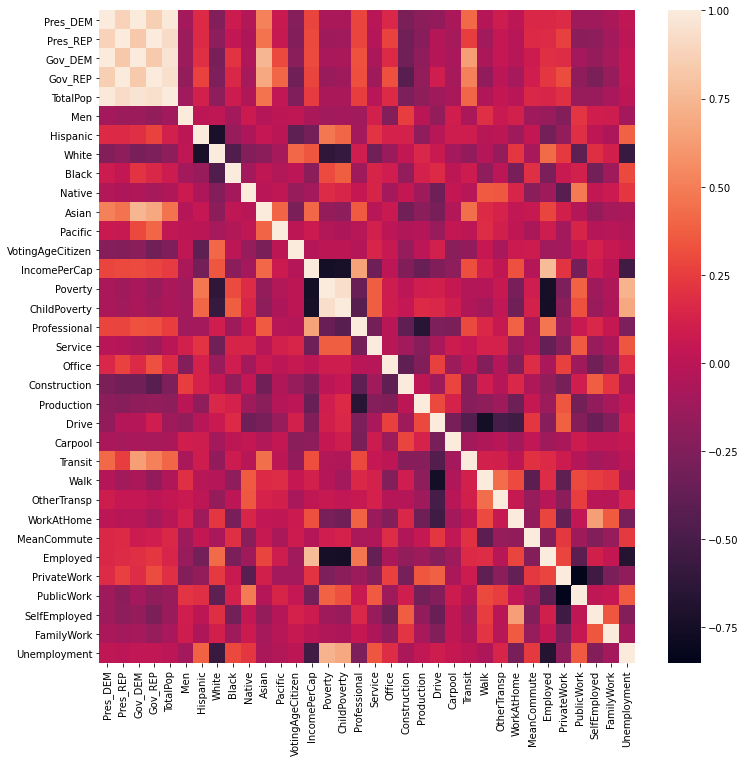

In [ ]:
# DataFrame의 corr() 메소드와 Seaborn의 heatmap() 메소드를 이용하여 Pearson's correlation 시각화하기
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr())

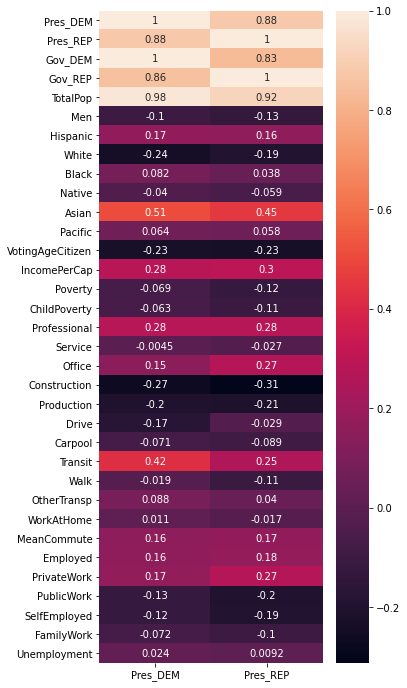

In [ ]:
# DataFrame의 corr() 메소드와 Seaborn의 heatmap() 메소드를 이용하여 Pearson's correlation 시각화하기
plt.figure(figsize=(5, 12))
sns.heatmap(df.corr()[['Pres_DEM', 'Pres_REP']], annot=True)

In [ ]:
df_norm = df.copy()

In [ ]:
# 위의 보면 이상한게 민주당에 투표했으면, 공화당투표가 0이여야 하는데 이상함. 때문에 비율로 바꿔서 히트맵으로 다시 상관성확인
df_norm['Pres_DEM'] /= df['Pres_DEM'] + df['Pres_REP']
df_norm['Pres_REP'] /= df['Pres_DEM'] + df['Pres_REP']
df_norm['Gov_DEM'] /= df['Gov_DEM'] + df['Gov_REP']
df_norm['Gov_REP'] /= df['Gov_DEM'] + df['Gov_REP']

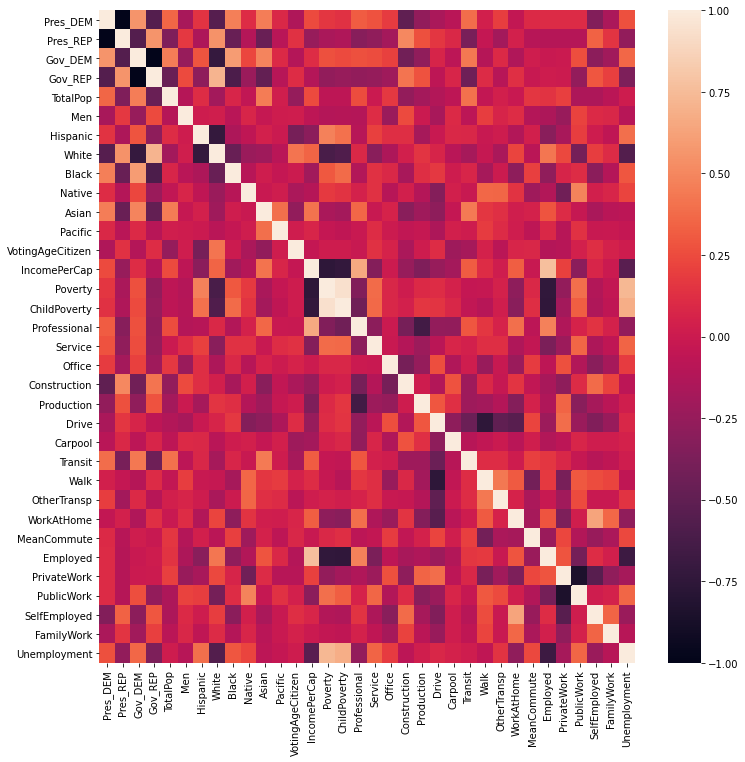

In [ ]:
# normalize된 데이터로 다시 correation 확인
plt.figure(figsize=(12, 12))
sns.heatmap(df_norm.corr())

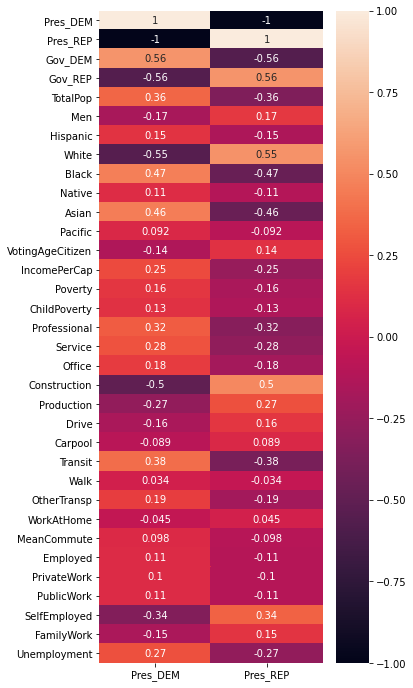

In [ ]:
plt.figure(figsize=(5, 12))
sns.heatmap(df_norm.corr()[['Pres_DEM', 'Pres_REP']], annot=True)

#### Seaborn을 이용하여 연관성 높은 데이터의 Jointplot 확인

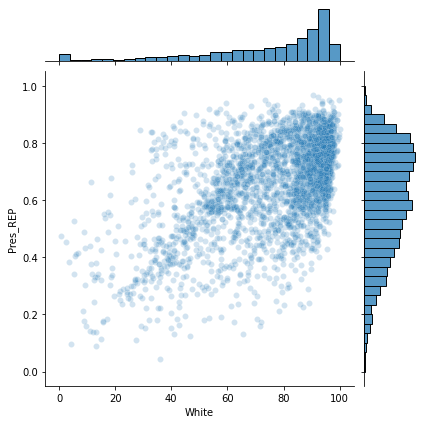

In [ ]:
sns.jointplot(x='White', y='Pres_REP', data=df_norm, alpha=0.2)

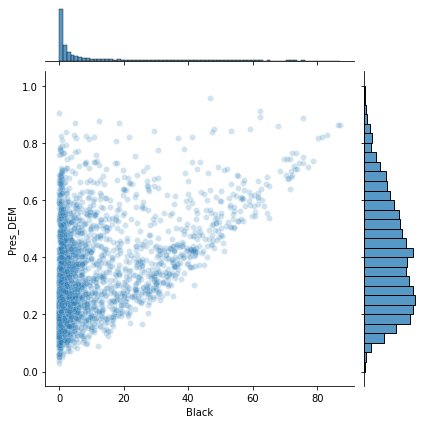

In [ ]:
sns.jointplot(x='Black', y='Pres_DEM', data=df_norm, alpha=0.2)

### Step 2. 모델 학습을 위한 전처리

#### 학습을 위한 데이터프레임 구성하기

In [ ]:
df_norm.columns

Index(['Pres_DEM', 'Pres_REP', 'Gov_DEM', 'Gov_REP', 'TotalPop', 'Men',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'VotingAgeCitizen', 'IncomePerCap', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment'],
      dtype='object')

In [ ]:
# 투표 결과에 해당하는 데이터는 입력 데이터에서 제거
# 예측 타겟은 DEM vs. REP 투표 비율로 한다.
df_norm.dropna(inplace=True)
X = df_norm.drop(['Pres_DEM', 'Pres_REP', 'Gov_DEM', 'Gov_REP'], axis=1)
y = df_norm['Pres_DEM']

#### MinMaxScaler를 이용해 수치형 데이터 표준화하기

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X = pd.DataFrame(data=X_scaled, index=X.index, columns=X.columns)

In [ ]:
X.head()

TotalPop       Men  ...  FamilyWork  Unemployment
state    county                                 ...                          
Delaware Kent County        0.081548  0.165303  ...      0.0250      0.350785
         New Castle County  0.261884  0.175099  ...      0.0125      0.340314
         Sussex County      0.101573  0.178030  ...      0.0125      0.319372
Indiana  Adams County       0.016322  0.236833  ...      0.0750      0.272251
         Allen County       0.173443  0.194232  ...      0.0125      0.329843

[5 rows x 30 columns]

#### 학습데이터와 테스트데이터 분리

In [ ]:
# train_test_split() 함수로 학습 데이터와 테스트 데이터 분리하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#### PCA를 이용해 데이터 전처리 수행하기

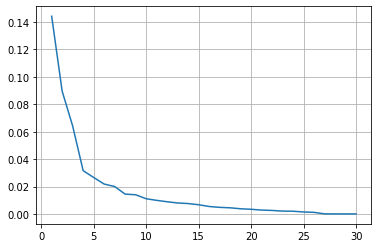

In [ ]:
pca = PCA()
pca.fit(X_train)
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
plt.grid()

In [ ]:
# 10에서 끊어준다.
pca = PCA(n_components=10)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)




### Step 3. Regression 모델 학습하기(y : 회귀유형)

-  데이터가 크기 때문에 LGBM만 하이퍼파라미터 조절을 통해 분석해본다.

In [ ]:
from lightgbm import LGBMRegressor as LGBM_R
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

#### 파라미터 그리드 설계

In [ ]:
# 모델 파라미터 그리드 설계
# 키가 모델의 함수, 값이 파라미터 그리드의 값
param_grid = dict() 

param_grid_for_LGBM_R = ParameterGrid({"max_depth": [2, 3, 4],
                                      "n_estimators": [50, 100],
                                      "learning_rate": [0.05, 0.1, 0.15, 0.2]})

param_grid[LGBM_R] = param_grid_for_LGBM_R


# 출력을 위한 max_iter_num 계산 
                            
# 튜닝 시작
best_score = 9999999999 
iteration_num = 0    
for k in range(30, 5, -1): 
    print(k)
  
    for model_func in [LGBM_R]:
        for param in param_grid[model_func]:
            model = model_func(**param).fit(pca.transform(X_train), y_train)
            y_pred = model.predict(pca.transform(X_test))
            score = MAE(y_test, y_pred)
            if score < best_score:
                best_model_func = model_func
                best_score = score
                best_parameter = param
            iteration_num += 1      


print("모델:", best_model_func)
print("점수:", best_score)
print("파라미터:", best_parameter)        


30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
모델: <class 'lightgbm.sklearn.LGBMRegressor'>
점수: 0.05897524310102912
파라미터: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}


In [ ]:
final_model_lgbm = LGBM_R(max_depth=3, n_estimators=50,learning_rate=0.2)
final_model_lgbm.fit(pca.transform(X_train), y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred = final_model_lgbm.predict(pca.transform(X_test))
print(MAE(y_test, pred))
print(sqrt(MSE(y_test, pred)))

0.05897524310102912
0.08439717837224664


In [ ]:
# y가 실수 값이기 때문에. 0.5기준으로
from sklearn.metrics import classification_report
print(classification_report(y_test > 0.5, pred > 0.5))


              precision    recall  f1-score   support

       False       0.98      0.96      0.97       146
        True       0.70      0.82      0.76        17

    accuracy                           0.94       163
   macro avg       0.84      0.89      0.86       163
weighted avg       0.95      0.94      0.95       163



### Step 4. Classification 모델 학습하기(y : 이진분류)

-  데이터가 크기 때문에 LGBM만 하이퍼파라미터 조절. 중요 변수를 보기 위해서 진행.

#### 파라미터 그리드 설계

In [ ]:
# 모델 파라미터 그리드 설계
# 키가 모델의 함수, 값이 파라미터 그리드의 값
param_grid = dict() 

param_grid_for_LGBM = ParameterGrid({"max_depth": [2, 3, 4],
                                      "n_estimators": [50, 100],
                                      "learning_rate": [0.05, 0.1, 0.15, 0.2]})

param_grid[LGBM] = param_grid_for_LGBM


# 출력을 위한 max_iter_num 계산 
# x,y가 실수로 있기때문에 분류더라도 0.5 기준으로 true, false로 만들어줘야함                           
# 튜닝 시작
best_score = 0
iteration_num = 0    
for k in range(30, 5, -1): 
    print(k)
  
    for model_func in [LGBM]:
        for param in param_grid[model_func]:
            model = model_func(**param).fit(X_train, y_train > 0.5)
            y_pred = model.predict(X_test)
            score = f1_score(y_test> 0.5, y_pred > 0.5, average = 'micro')
            if score > best_score:
                best_model_func = model_func
                best_score = score
                best_parameter = param
            iteration_num += 1      


print("모델:", best_model_func)
print("점수:", best_score)
print("파라미터:", best_parameter)        


30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
모델: <class 'lightgbm.sklearn.LGBMClassifier'>
점수: 0.9631901840490797
파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [ ]:
model_lgbm=LGBM(max_depth=3, n_estimators=50,learning_rate=0.1)
model_lgbm.fit(X_train, y_train> 0.5)
pred_lgbm = model_lgbm.predict(X_test)
print(classification_report(y_test> 0.5, pred_lgbm> 0.5))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98       146
        True       0.92      0.71      0.80        17

    accuracy                           0.96       163
   macro avg       0.94      0.85      0.89       163
weighted avg       0.96      0.96      0.96       163



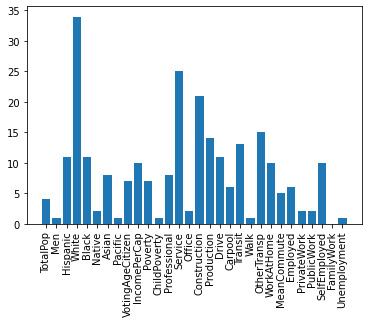

In [ ]:
plt.bar(X.columns, model_lgbm.feature_importances_)
plt.xticks(rotation=90)
plt.show()

#### Precision-Recall 커브와 ROC 커브 그리기

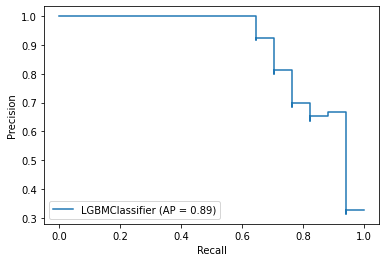

In [ ]:
fig = plt.figure()
ax = fig.gca()
plot_precision_recall_curve(model_lgbm, X_test, y_test >0.5, ax=ax)

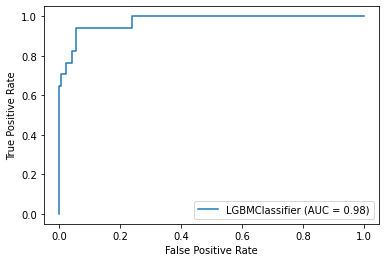

In [ ]:
fig = plt.figure()
ax = fig.gca()
plot_roc_curve(model_lgbm, X_test, y_test >0.5, ax=ax)

### Step 4. 딥러닝.신경망 모델로 분석

In [ ]:
from keras.optimizers import Adam

In [ ]:
print(X_train.shape, y_train.shape)

(379, 30) (379,)


#### 모델구현

In [ ]:
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',input_shape=(30,)))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                5

In [ ]:
# 콜백 함수 적용 부분(분류모델은 val_loss로)
early_stopping_callback = EarlyStopping(monitor='loss', mode='min', patience=10)
# 분류모델이면 model_checkpoint = ModelCheckpoint(filepath='./{epoch}-{val_loss:.2f}-{val_accuracy:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제5_딥러닝파라미터/{epoch}-{loss:.2f}.h5', 
                                   monitor='loss', save_best_only=True, verbose=1)


history = model.fit(X_train, y_train, batch_size=16,  epochs=1000,
            callbacks=[early_stopping_callback, model_checkpoint],
            validation_data=(X_test, y_test))

Epoch 1/1000
24/24 [==============================] - 3s 15ms/step - loss: 2.0400 - mae: 1.1159 - val_loss: 0.0542 - val_mae: 0.1953

Epoch 00001: loss improved from inf to 1.52944, saving model to /content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제5_딥러닝파라미터/1-1.53.h5
Epoch 2/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.7690 - mae: 0.6819 - val_loss: 0.0191 - val_mae: 0.1023

Epoch 00002: loss improved from 1.52944 to 0.68456, saving model to /content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제5_딥러닝파라미터/2-0.68.h5
Epoch 3/1000
24/24 [==============================] - 0s 7ms/step - loss: 0.5778 - mae: 0.6074 - val_loss: 0.0289 - val_mae: 0.1471

Epoch 00003: loss improved from 0.68456 to 0.49750, saving model to /content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제5_딥러닝파라미터/3-0.50.h5
Epoch 4/1000
24/24 [==============================] - 0s 7ms/step - loss: 0.3904 - mae: 0.4954 - val_loss: 0.0306 - val_m

#### 딥러닝 모델 평가

In [ ]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.0113 - mae: 0.0818


[0.011259224265813828, 0.08183074742555618]

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [ ]:
print(model.predict(X_test[5:10]))
print(y_test[5:10])

[[0.23808025]
 [0.4855392 ]
 [0.34269065]
 [0.32096112]
 [0.49490786]]
state          county         
West Virginia  Jackson County     0.241128
Montana        Gallatin County    0.538900
Missouri       Scott County       0.214188
Indiana        LaPorte County     0.463138
Delaware       Kent County        0.520705
Name: Pres_DEM, dtype: float64


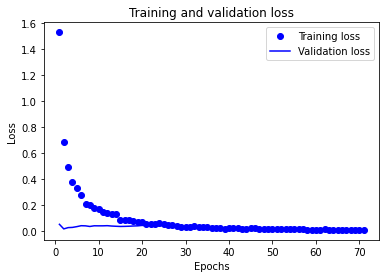

In [ ]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

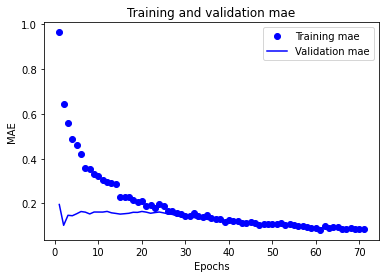

In [ ]:
plt.clf()   # 그래프를 초기화합니다
mae = history.history['mae'] 
val_mae = history.history['val_mae'] 

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()